In [1]:
# Import all the libraries needed

import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import spacy
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, r2_score
import optuna
import catboost
from surprise import Reader, Dataset
from surprise import SVDpp

In [2]:
#Read the datasets
train = pd.read_csv('/content/drive/MyDrive/EngagementScorePrediction/train_0OECtn8.csv')
test = pd.read_csv('/content/drive/MyDrive/EngagementScorePrediction/test_1zqHu22.csv')
submission = pd.read_csv('/content/drive/MyDrive/EngagementScorePrediction/sample_submission_JPlpRcN.csv')

In [3]:
train.head()

,row_id,user_id,category_id,video_id,age,gender,profession,followers,views,engagement_score
0,1,19990,37,128,24,Male,Student,180,1000,4.33
1,2,5304,32,132,14,Female,Student,330,714,1.79
2,3,1840,12,24,19,Male,Student,180,138,4.35
3,4,12597,23,112,19,Male,Student,220,613,3.77
4,5,13626,23,112,27,Male,Working Professional,220,613,3.13


##Quick data analysis

In [4]:
dup_bool = train.duplicated(['user_id','video_id','engagement_score'])
dups = sum(dup_bool)
print("There are {} duplicate rating entries in the data.".format(dups))

There are 0 duplicate rating entries in the data.


In [5]:
print('no of users in train data = {}'.format(len(train.user_id.unique())))

no of users in train data = 27734


In [6]:
print('no of users in test data = {}'.format(len(test.user_id.unique())))

no of users in test data = 10384


In [7]:
print('no of video_id in train data = {}'.format(len(train.video_id.unique())))

no of video_id in train data = 175


In [8]:
print('no of video_id in test data = {}'.format(len(test.video_id.unique())))

no of video_id in test data = 128


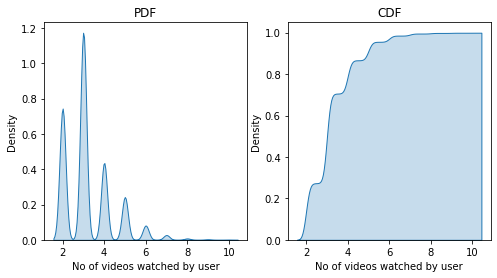

In [9]:
no_of_engaged_videos_per_user = train.groupby(by='user_id')['engagement_score'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sn.kdeplot(no_of_engaged_videos_per_user, shade=True, ax=ax1)
plt.xlabel('No of videos watched by user')
plt.title("PDF")

ax2 = plt.subplot(122)
sn.kdeplot(no_of_engaged_videos_per_user, shade=True, cumulative=True,ax=ax2)
plt.xlabel('No of videos watched by user')
plt.title('CDF')

plt.show()

Most no of people have watched 3 videos (median)

90% of the users watched less than 6 videos

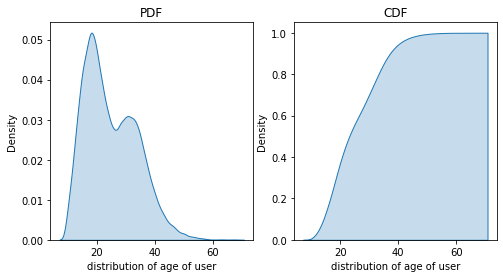

In [10]:
fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sn.kdeplot(train.age, shade=True, ax=ax1)
plt.xlabel('distribution of age of user')
plt.title("PDF")

ax2 = plt.subplot(122)
sn.kdeplot(train.age, shade=True, cumulative=True,ax=ax2)
plt.xlabel('distribution of age of user')
plt.title('CDF')

plt.show()

90% of the viewers are of age less than 40

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


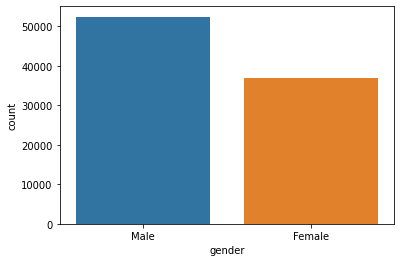

In [11]:
sn.countplot(train.gender)
plt.show()

There are more male users than female 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


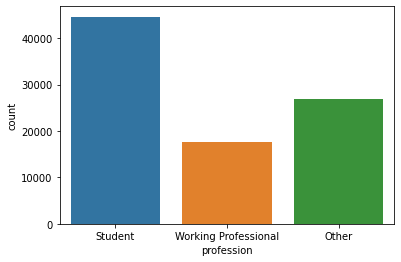

In [12]:
sn.countplot(train.profession)
plt.show()

There are more students as the distribution of age is also skewed towards right

In [13]:
print('Global average engagement_score = {}'.format(train.engagement_score.mean()))

Global average engagement_score = 3.487797011110046


In [14]:
print('videos present in test not in train = {}'.format(len(set(test.video_id) - set(train.video_id))))

videos present in test not in train = 0


In [15]:
print('users present in test not in train = {}'.format(len(set(test.user_id) - set(train.user_id))))

users present in test not in train = 0


##Feature Engineering

In [16]:
#splitting the data and removing id column
train, validation = train_test_split(train, test_size=0.2, random_state=12)
train = train.reset_index()
validation = validation.reset_index()
train = train.drop(['row_id'], axis=1)
test = test.drop(['row_id'], axis=1)
validation = validation.drop(['row_id'], axis=1)

In [17]:
#avg score of every user and video
user_avarage_rating = train.groupby('user_id')['engagement_score'].mean().to_dict()
video_average_rating = train.groupby('video_id')['engagement_score'].mean().to_dict()

In [18]:
for user in validation.user_id:
  if user not in user_avarage_rating.keys():
    user_avarage_rating[user] = train.engagement_score.mean()
    
for video in validation.video_id:
  if video not in video_average_rating.keys():
    video_average_rating[user] = train.engagement_score.mean()

In [19]:
def get_user_video_matrix(data):
  matrix = np.zeros((27734, 175))

  for i in range(len(data)):
    matrix[data.user_id[i] - 1][data.video_id[i] - 1] = data.engagement_score[i]

  return csr_matrix(matrix)

train_matrix = get_user_video_matrix(train)

In [20]:
#get cosine similarity between users to get similar users and get cosine similarity between videos to get similar videos
usersim = cosine_similarity(train_matrix)
vidsim = cosine_similarity(train_matrix.T)

In [21]:
def get_features(usersim = usersim, vidsim = vidsim, df = train, train_matrix = train_matrix, user_avarage_rating = user_avarage_rating, video_average_rating = video_average_rating):
  output = []
  for i in tqdm(range(len(df))):
    o = []
    uid = df.user_id[i]
    vid = df.video_id[i]

    #--------------------- Ratings of "video" by similar users of "user" and the similarity ---------------------

    top_sim_users = usersim[uid-1].argsort()[::-1][1:]
    top_scores = train_matrix[top_sim_users, vid-1].toarray().ravel()
    top_sim = usersim[uid-1][top_sim_users]
    top_sim_users_score = list(top_scores[top_scores != 0][:5])
    top_sim_users_similarity = list(top_sim[top_scores != 0][:5])
    top_sim_users_score.extend([user_avarage_rating[uid]]*(5 - len(top_sim_users_score)))
    top_sim_users_similarity.extend([1.0]*(5 - len(top_sim_users_score)))
    o.extend(top_sim_users_score)
    o.extend(top_sim_users_similarity)

    #--------------------- Ratings by "user"  to similar movies of "video" and the similarity ---------------------

    top_sim_vids = vidsim[vid-1].argsort()[::-1][1:]
    top_scores = train_matrix[uid-1, top_sim_vids].toarray().ravel()
    top_sim = vidsim[vid-1][top_sim_vids]
    top_sim_vids_score = list(top_scores[top_scores != 0][:5])
    top_sim_vids_similarity = list(top_sim[top_scores != 0][:5])
    top_sim_vids_score.extend([video_average_rating[vid]]*(5 - len(top_sim_vids_score)))
    top_sim_vids_similarity.extend([1.0]*(5 - len(top_sim_vids_score)))
    o.extend(top_sim_vids_score)
    o.extend(top_sim_vids_similarity)

    output.append(o)

  return output

In [23]:
#Get the newly created features
features = get_features()
testfeatures = get_features(df=test)
validfeatures = get_features(df=validation)

100%|██████████| 17840/17840 [01:02<00:00, 285.22it/s]


In [24]:
similars = pd.DataFrame(features, columns = ['sur1', 'sur2', 'sur3', 'sur4', 'sur5','sus1', 'sus2', 'sus3', 'sus4', 'sus5','smr1', 'smr2', 'smr3', 'smr4', 'smr5','sms1', 'sms2', 'sms3', 'sms4', 'sms5'])
testsimilars = pd.DataFrame(testfeatures, columns = ['sur1', 'sur2', 'sur3', 'sur4', 'sur5','sus1', 'sus2', 'sus3', 'sus4', 'sus5','smr1', 'smr2', 'smr3', 'smr4', 'smr5','sms1', 'sms2', 'sms3', 'sms4', 'sms5'])
validationsimilars = pd.DataFrame(validfeatures, columns = ['sur1', 'sur2', 'sur3', 'sur4', 'sur5','sus1', 'sus2', 'sus3', 'sus4', 'sus5','smr1', 'smr2', 'smr3', 'smr4', 'smr5','sms1', 'sms2', 'sms3', 'sms4', 'sms5'])

In [25]:
similarstrain = pd.concat([train,similars], axis=1 )
similarstest = pd.concat([test,testsimilars], axis=1 )
similarsvalidation = pd.concat([validation,validationsimilars], axis=1 )

In [26]:
similarstrain.gender[similarstrain.gender != 'Male'] = 1
similarstrain.gender[similarstrain.gender == 'Male'] = 0

similarstrain.profession[similarstrain.profession == 'Student'] = 1
similarstrain.profession[similarstrain.profession == 'Other'] = 0
similarstrain.profession[similarstrain.profession == 'Working Professional'] = -1

similarstrain.gender = similarstrain.gender.astype('int')
similarstrain.profession = similarstrain.profession.astype('int')


similarstest.gender[similarstest.gender != 'Male'] = 1
similarstest.gender[similarstest.gender == 'Male'] = 0

similarstest.profession[similarstest.profession == 'Student'] = 1
similarstest.profession[similarstest.profession == 'Other'] = 0
similarstest.profession[similarstest.profession == 'Working Professional'] = -1

similarstest.gender = similarstest.gender.astype('int')
similarstest.profession = similarstest.profession.astype('int')


similarsvalidation.gender[similarsvalidation.gender != 'Male'] = 1
similarsvalidation.gender[similarsvalidation.gender == 'Male'] = 0

similarsvalidation.profession[similarsvalidation.profession == 'Student'] = 1
similarsvalidation.profession[similarsvalidation.profession == 'Other'] = 0
similarsvalidation.profession[similarsvalidation.profession == 'Working Professional'] = -1

similarsvalidation.gender = similarsvalidation.gender.astype('int')
similarsvalidation.profession = similarsvalidation.profession.astype('int')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3

In [27]:
similarstrain['user_avarage_rating'] = [user_avarage_rating[i] for i in similarstrain.user_id]
similarstest['user_avarage_rating'] = [user_avarage_rating[i] for i in similarstest.user_id]
similarsvalidation['user_avarage_rating'] = [user_avarage_rating[i] for i in similarsvalidation.user_id]

similarstrain['video_average_rating'] = [video_average_rating[i] for i in similarstrain.video_id]
similarstest['video_average_rating'] = [video_average_rating[i] for i in similarstest.video_id]
similarsvalidation['video_average_rating'] = [video_average_rating[i] for i in similarsvalidation.video_id]

similarstrain['global_avg'] = train.engagement_score.mean()
similarstest['global_avg'] = train.engagement_score.mean()
similarsvalidation['global_avg'] = train.engagement_score.mean()

In [28]:
similarstrain = similarstrain.drop(['index'], axis=1)
similarsvalidation = similarsvalidation.drop(['index'], axis=1)

In [29]:
similarstrain.head()

,user_id,category_id,video_id,age,gender,profession,followers,views,engagement_score,sur1,sur2,sur3,sur4,sur5,sus1,sus2,sus3,sus4,sus5,smr1,smr2,smr3,smr4,smr5,sms1,sms2,sms3,sms4,sms5,user_avarage_rating,video_average_rating,global_avg
0,26674,16,98,22,1,1,270,462,4.62,4.29,3.04,4.35,4.06,3.87,0.915674,0.866824,0.866075,0.858844,0.833997,2.480000,2.480000,2.600000,3.627566,3.627566,0.246691,0.097994,0.077599,NaN,NaN,3.045000,3.627566,3.488828
1,11605,11,41,27,1,0,250,180,2.30,2.16,3.23,3.19,2.48,2.70,0.997630,0.995723,0.941269,0.885563,0.878779,2.480000,2.560000,3.407703,3.407703,3.407703,0.230163,0.189935,NaN,NaN,NaN,2.446667,3.407703,3.488828
2,10185,33,93,32,1,0,270,862,3.43,4.14,3.13,3.87,3.40,2.80,0.999943,0.999859,0.998993,0.998748,0.998097,3.370000,3.430000,3.326000,3.326000,3.326000,0.065946,0.054328,NaN,NaN,NaN,3.410000,3.326000,3.488828
3,4967,10,21,17,1,1,210,44,2.60,2.80,2.56,2.70,3.87,3.76,0.999917,0.999910,0.991614,0.979073,0.975528,4.350000,2.350000,3.601879,3.601879,3.601879,0.372037,0.161640,NaN,NaN,NaN,3.100000,3.601879,3.488828
4,10329,41,130,33,0,-1,240,72,3.63,3.58,4.02,3.14,2.64,4.31,1.000000,1.000000,1.000000,1.000000,1.000000,3.641773,3.641773,3.641773,3.641773,3.641773,NaN,NaN,NaN,NaN,NaN,3.630000,3.641773,3.488828


Training Model

In [30]:
xtrain,xtest = similarstrain.drop(['engagement_score'], axis=1) , similarsvalidation.drop(['engagement_score'], axis=1)
ytrain,ytest = similarstrain.engagement_score, similarsvalidation.engagement_score

In [31]:
# These parameters are found with the help of hyperparameter optimizing library optuna
lgbmparams = {'iterations': 200, 'reg_alpha': 1.9160236698846917, 'reg_lambda': 0.009038089209425539, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 22, 'min_child_samples': 8, 'min_data_per_groups': 15}
catboostparams = {'iterations': 400, 'learning_rate': 0.017245230233596254, 'depth': 8, 'l2_leaf_reg': 863.4098881182281, 'colsample_bylevel': 0.09993102325290629, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}

In [32]:
lb = lgb.LGBMRegressor(**lgbmparams,  random_state=12, verbose=0)
lb.fit(xtrain, ytrain)

cb = catboost.CatBoostRegressor(**catboostparams, random_state=12, verbose=0,)
cb.fit(xtrain, ytrain)

In [33]:
my_submission = pd.DataFrame({'row_id': submission.row_id, 'engagement_score': (lb.predict(similarstest)+cb.predict(similarstest))/2})
my_submission.to_csv('submission.csv', index=False)

This submission had got me r2 score of 0.298 on public test set

## Trying MCM method to calculate engagement score

In [34]:
#Creating the dataset to feed into svdpp algorithm
reader = Reader(rating_scale=(0, 5))
train_data = Dataset.load_from_df(train[['user_id', 'video_id', 'engagement_score']], reader)
trainset = train_data.build_full_trainset() 

In [35]:
validationset = list(zip(validation.user_id.values, validation.video_id.values, validation.engagement_score.values))

In [36]:
# These parameters are found with the help of hyperparameter optimizing library optuna
svdppparameters = {'lr_bi': 0.00979687062134178,
 'lr_bu': 0.04072947707311226,
 'lr_pu': 0.05837529374774398,
 'lr_qi': 0.08106330574427646,
 'reg_bi': 0.00018355232360930474,
 'reg_bu': 0.000980078300980912,
 'reg_pu': 0.0001003873956431923,
 'reg_qi': 0.08115660409360344}

In [37]:
# You can read about the svd++ algorithm here https://surprise.readthedocs.io/en/stable/matrix_factorization.html
svdpp = SVDpp(**svdppparameters,n_factors=100, random_state=12, verbose=0)
svdpp.fit(trainset)

In [38]:
testset = list(zip(test.user_id.values, test.video_id.values, test.age.values))
test_preds = svdpp.test(testset)
pred = np.array([pred.est for pred in test_preds])

In [39]:
my_submission = pd.DataFrame({'row_id': submission.row_id, 'engagement_score': pred})
my_submission.to_csv('submission.csv', index=False)

This submission got me 0.49568953569085 r2score on public test data